# Customer Clustering

In [2]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns
import scipy.stats as sp
import random
import psycopg2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score,confusion_matrix, classification_report, roc_auc_score
from sklearn.datasets import make_blobs
from matplotlib import cm
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## データ読み込み

In [24]:
train_data = pd.read_csv("train.csv")

In [34]:
book_data = train_data[
            (train_data['booking_bool']==True)
           &(train_data['site_id']==5)
           &(train_data['visitor_location_country_id']==219)
           &(train_data['prop_country_id']==219)
][
            ['srch_id',
             'date_time',
             'site_id',
             'visitor_location_country_id',
             'visitor_hist_starrating',
             'visitor_hist_adr_usd',
             'prop_country_id',
             'prop_id',
             'prop_starrating',
             'prop_review_score',
             'prop_brand_bool',
             'prop_location_score1',
             'prop_location_score2',
             'prop_log_historical_price',
             'price_usd',
             'promotion_flag',
             'srch_destination_id',
             'srch_length_of_stay',
             'srch_booking_window',
             'srch_adults_count',
             'srch_children_count',
             'srch_room_count',
             'srch_saturday_night_bool',
             'orig_destination_distance',
             'click_bool',
             'gross_bookings_usd',
             'booking_bool']
].reset_index()

In [36]:
book_data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,click_bool,gross_bookings_usd,booking_bool
0,8,2013-03-20 17:50:44,5,219,NaN,NaN,219,27669,3,3.5,...,1,0,1,0,1,False,4.17,True,96.41,True
1,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,23228,4,4.0,...,1,0,2,0,1,False,767.86,True,47.10,True
2,28,2012-11-26 10:13:17,5,219,NaN,NaN,219,13996,4,4.0,...,3,27,1,0,1,False,116.14,True,286.32,True
3,39,2013-04-06 18:08:58,5,219,NaN,NaN,219,109855,2,3.5,...,1,7,2,2,1,True,53.92,True,60.77,True
4,53,2013-02-13 07:00:24,5,219,NaN,NaN,219,101178,4,4.5,...,2,16,2,0,1,True,0.29,True,347.65,True


In [37]:
print('Number of Rows: %i   Number of Columns: %i' % book_data.shape)

Number of Rows: 118762   Number of Columns: 27


In [32]:
book_data.describe()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,orig_destination_distance,gross_bookings_usd
count,443672.000000,443672.000000,443672.000000,22376.000000,22485.000000,443672.000000,443672.000000,443672.000000,443172.000000,443672.000000,...,4.436720e+05,443672.000000,443672.000000,443672.000000,443672.000000,443672.000000,443672.000000,443672.000000,294295.000000,276592.000000
mean,332850.974891,10.269296,173.699231,3.382377,178.263211,171.865362,70134.936363,3.331055,3.891276,0.637126,...,2.579978e+02,0.291330,14089.902579,2.416648,38.096984,1.991426,0.369018,1.124892,1331.336091,386.530099
std,192214.230136,7.838085,66.496746,0.695851,111.048246,69.072821,40713.164278,0.969947,0.892761,0.480829,...,1.422812e+04,0.454376,8150.911591,2.102637,52.899932,0.887687,0.749109,0.443546,2061.265450,801.073164
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.010000,0.000000
25%,166627.750000,5.000000,100.000000,2.930000,111.090000,100.000000,34800.000000,3.000000,3.500000,0.000000,...,8.483000e+01,0.000000,7037.000000,1.000000,4.000000,2.000000,0.000000,1.000000,142.175000,124.240000
50%,332714.000000,5.000000,219.000000,3.450000,152.810000,219.000000,69580.000000,3.000000,4.000000,1.000000,...,1.181900e+02,0.000000,13703.000000,2.000000,17.000000,2.000000,0.000000,1.000000,387.720000,219.420000
75%,499621.250000,14.000000,219.000000,3.960000,215.680000,219.000000,105236.000000,4.000000,4.500000,1.000000,...,1.690200e+02,1.000000,21193.000000,3.000000,49.000000,2.000000,0.000000,1.000000,1537.865000,431.760000
max,665574.000000,34.000000,231.000000,5.000000,2768.930000,230.000000,140821.000000,5.000000,5.000000,1.000000,...,3.799323e+06,1.000000,28416.000000,59.000000,498.000000,9.000000,9.000000,8.000000,11684.410000,167740.590000


In [33]:
book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443672 entries, 0 to 443671
Data columns (total 27 columns):
srch_id                        443672 non-null int64
date_time                      443672 non-null datetime64[ns]
site_id                        443672 non-null int64
visitor_location_country_id    443672 non-null int64
visitor_hist_starrating        22376 non-null float64
visitor_hist_adr_usd           22485 non-null float64
prop_country_id                443672 non-null int64
prop_id                        443672 non-null int64
prop_starrating                443672 non-null int64
prop_review_score              443172 non-null float64
prop_brand_bool                443672 non-null int64
prop_location_score1           443672 non-null float64
prop_location_score2           390847 non-null float64
prop_log_historical_price      443672 non-null float64
price_usd                      443672 non-null float64
promotion_flag                 443672 non-null int64
srch_destination_id 

## データ理解

## データ加工

〜省略〜

### 欠損値

###### 欠損値チェック

In [39]:
col_names = book_data.columns
n = book_data.shape[0]
for col_name in col_names:
    missing_num = sum(pd.isnull(book_data[col_name]))
    if missing_num > 0:
        print(col_name, '; # of missing record: ', missing_num, 'ratio:',missing_num/n)

visitor_hist_starrating ; # of missing record:  112634 ratio: 0.948401003688
visitor_hist_adr_usd ; # of missing record:  112606 ratio: 0.948165238039
prop_review_score ; # of missing record:  21 ratio: 0.000176824236709
prop_location_score2 ; # of missing record:  13515 ratio: 0.113799026625
orig_destination_distance ; # of missing record:  14769 ratio: 0.124357959617


###### 欠損値を固定値で埋める

###### visitor_hist_book(欠損値補完前にnullをフラグ立てる)

In [41]:
def hist_book(x):
    if x >0:
        return int(1)
    else:
        return int(0)

In [42]:
book_data['visitor_hist_book'] = book_data['visitor_hist_adr_usd'].apply(hist_book)

平均で埋める

In [45]:
na_mean_cols = ['visitor_hist_starrating', 'visitor_hist_adr_usd'
    ,'prop_review_score', 'prop_location_score2','orig_destination_distance']
for i in na_mean_cols:
    book_data[i] = book_data[i].transform(lambda x: x.fillna(x.mean()))

### 変数作成

検索日

In [46]:
#日付データ型に変換
book_data['date_time'] = pd.to_datetime(book_data['date_time'])

#検索日時（date_time）を月、時間、曜日に分解
book_data['date_month'] = book_data['date_time'].dt.month
book_data['date_hour'] = book_data['date_time'].dt.hour
book_data['date_week'] = book_data['date_time'].dt.weekday_name
book_data['date_dow'] = book_data['date_time'].dt.dayofweek

宿泊日

In [48]:
temp_data = []
for i in range(0,len(book_data)):
    x = book_data['date_time'].iloc[i] + pd.offsets.Day(book_data['srch_booking_window'].iloc[i])
    temp_data.append(x)

In [49]:
book_data['stay_date_time'] = temp_data
book_data['stay_date'] = book_data['stay_date_time'].dt.date
book_data['stay_date_month'] = book_data['stay_date_time'].dt.month
book_data['stay_date_week'] = book_data['stay_date_time'].dt.weekday_name
book_data['stay_date_dow'] = book_data['stay_date_time'].dt.dayofweek

In [51]:
def high_season(x):
    if x >= 11:
        return int(1)
    else:
        return int(0)

In [52]:
book_data['high_season_flg'] = book_data['stay_date_month'].apply(high_season)

###### falmily_flg

In [54]:
def family(x):
    if x >= 1:
        return int(1)
    else:
        return int(0)

In [55]:
book_data['family_flg'] = book_data['srch_children_count'].apply(family)

###### business_flg

In [57]:
book_data['business_flg'] = int(0)

In [58]:
book_data.loc[np.logical_and(book_data['srch_adults_count'] == 1,book_data['srch_children_count'] == 0), ['business_flg']] = int(1)

###### executive_flg

In [60]:
def executive(x):
    if x >= 5000:
        return int(1)
    else:
        return int(0)

In [61]:
book_data['executive_flg'] = book_data['gross_bookings_usd'].apply(executive)

1stay_price

In [63]:
book_data['1stay_price'] = book_data['gross_bookings_usd']/book_data['srch_length_of_stay']

price_class

In [66]:
def price_class(x):
    cnt = 10
    max_class = 10000
    if x >= max_class*cnt:
        return int(max_class*cnt)
    elif x >= 1*cnt and x < max_class*cnt:
        for i in range(1,max_class+1):
            if i ==1:
                if x >= 1*cnt and x < 2*cnt:
                    return int(i*cnt)
            elif i >= 2:
                if x >= i*cnt and x < (i+1)*cnt:
                    return int(i*cnt)
    else:
        return int(0)

In [67]:
book_data['price_class'] = book_data['gross_bookings_usd'].apply(price_class)

In [69]:
#変換できてるかチェック
book_data.ix[book_data['gross_bookings_usd']>=8000][['gross_bookings_usd','price_class']].head()

,gross_bookings_usd,price_class
8568,94970.00,94970
13611,10022.92,10020
27210,8112.80,8110
37271,10485.00,10480
50506,11056.72,11050


###### srch_saturday_night_bool

In [70]:
def saturday(x):
    if x == True:
        return int(1)
    else:
        return int(0)

In [71]:
book_data['srch_saturday_night_flg'] = book_data['srch_saturday_night_bool'].apply(saturday)

###### srch_destination_id

In [73]:
dest_rank_master = book_data.groupby('srch_destination_id').aggregate({'srch_id':len}).sort_values(['srch_id'],ascending=False).head(10).reset_index()
dest_rank_master

,srch_destination_id,srch_id
0,8192,2060
1,4562,1176
2,9402,1147
3,13870,917
4,8347,894
5,18774,856
6,23904,773
7,13216,724
8,26067,679
9,15307,645


In [74]:
def dest_rank_top10(x):
    if x == 8192:
        return int(1)
    elif x == 4562:
        return int(2)
    elif x == 9402:
        return int(3)
    elif x == 18774:
        return int(4)
    elif x == 13870:
        return int(5)
    elif x == 8347:
        return int(6)
    elif x == 23904:
        return int(7)
    elif x == 13216:
        return int(8)
    elif x == 26067:
        return int(9)
    elif x == 15307:
        return int(10)
    else:
        return int(0)

In [75]:
book_data['dest_rank'] = book_data['srch_destination_id'].apply(dest_rank_top10)

###### srch_booking_window

何週目

In [77]:
def win_week(x):
    if x > 0:
        return int(np.ceil(x/7))
    else:
        return int(1)

In [78]:
book_data['window_week'] = book_data['srch_booking_window'].apply(win_week)

当日

In [80]:
def win_today(x):
    if x == 0:
        return int(1)
    else:
        return int(0)

In [81]:
book_data['window_today'] = book_data['srch_booking_window'].apply(win_today)

前日

In [83]:
def win_previous_day(x):
    if x == 1:
        return int(1)
    else:
        return int(0)

In [84]:
book_data['window_previous_day'] = book_data['srch_booking_window'].apply(win_previous_day)

###### price

prop_historical_price

In [88]:
book_data['prop_historical_price'] = np.exp(book_data['prop_log_historical_price'])
# book_data['season_price'] = (book_data['1stay_1night_price']/book_data['prop_historical_price'])*1.0 

special_price

In [90]:
book_data['special_price'] = 1-(np.log(book_data['price_usd'])/book_data['prop_log_historical_price'])

##### long_stay

In [92]:
def long_stay(x):
    if x >= 5:
        return int(1)
    else:
        return int(0)

In [93]:
book_data['long_stay_flg'] = book_data['srch_length_of_stay'].apply(long_stay)

##### srch_evening

In [95]:
def srch_evening(x):
    if x >= 16 and x <= 19:
        return int(1)
    else:
        return int(0)

In [96]:
book_data['srch_evening_flg'] = book_data['date_hour'].apply(srch_evening)

## K-Meansによるクラスタリング

### 変数選択

In [98]:
exclude_cols = ['srch_id','prop_id'
                ,'site_id','visitor_location_country_id','prop_country_id'
                ,'click_bool','booking_bool'
                ,'date_time','date_week','srch_saturday_night_bool','srch_booking_window'
                ,'stay_date','stay_date_time','stay_date_week'
                ,'dest_rank','cluster_id'
                ,'high_season_flg','stay_date_month','long_stay_flg'
                ,'executive_flg','1stay_price','gross_bookings_usd'
                ,'prop_log_historical_price','prop_historical_price']

In [101]:
feature_cols = [col for col in book_data.columns if col not in exclude_cols]

In [102]:
feature_cols

['visitor_hist_starrating',
 'visitor_hist_adr_usd',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'orig_destination_distance',
 'visitor_hist_book',
 'date_month',
 'date_hour',
 'date_dow',
 'stay_date_dow',
 'family_flg',
 'business_flg',
 'price_class',
 'srch_saturday_night_flg',
 'window_week',
 'window_today',
 'window_previous_day',
 'special_price',
 'srch_evening_flg']

In [103]:
data = book_data[feature_cols]

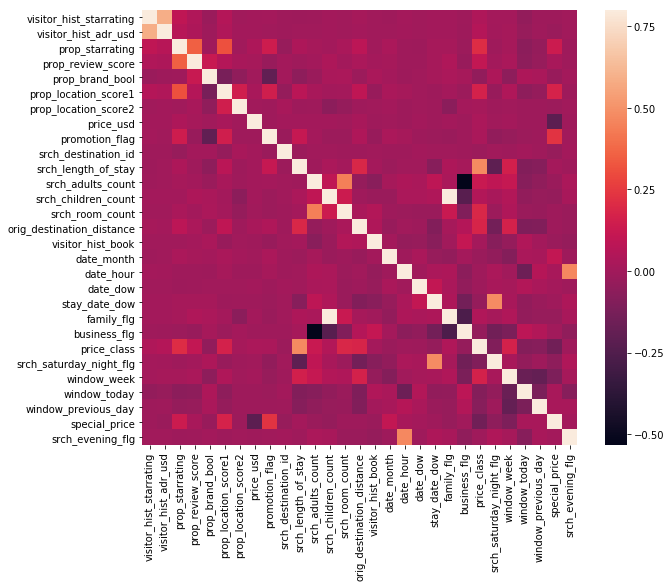

In [104]:
#特徴量相関マップ
corrmat = data.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [107]:
data.head()

,visitor_hist_starrating,visitor_hist_adr_usd,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,price_usd,promotion_flag,srch_destination_id,...,stay_date_dow,family_flg,business_flg,price_class,srch_saturday_night_flg,window_week,window_today,window_previous_day,special_price,srch_evening_flg
0,3.00681,157.088418,3,3.5,1,3.00,0.2107,85.0,0,7082,...,2,0,1,90,0,1,1,0,0.038387,1
1,3.00681,157.088418,4,4.0,0,3.26,0.3676,42.0,1,3735,...,1,0,0,40,0,1,1,0,0.158183,0
2,3.00681,157.088418,4,4.0,1,2.89,0.0491,85.0,0,24232,...,6,0,1,280,0,4,0,0,0.123737,0
3,3.00681,157.088418,2,3.5,1,1.10,0.3217,55.0,0,24361,...,5,1,0,60,1,1,0,0,0.010535,1
4,3.00681,157.088418,4,4.5,1,3.91,0.1399,151.0,1,7434,...,4,0,0,340,1,3,0,0,0.062191,0


In [108]:
data.describe()

,visitor_hist_starrating,visitor_hist_adr_usd,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,price_usd,promotion_flag,srch_destination_id,...,stay_date_dow,family_flg,business_flg,price_class,srch_saturday_night_flg,window_week,window_today,window_previous_day,special_price,srch_evening_flg
count,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,...,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000
mean,3.006810,157.088418,3.070755,3.973404,0.774532,2.489738,0.188470,130.092934,0.260605,14000.591115,...,3.384702,0.234890,0.186255,293.850558,0.578459,3.878219,0.096529,0.110961,0.055352,0.254543
std,0.143254,23.949063,0.880631,0.662440,0.417892,1.266704,0.175663,942.053846,0.438967,8086.204654,...,1.807092,0.423932,0.389314,462.130531,0.493808,5.450776,0.295317,0.314086,0.062421,0.435606
min,1.000000,5.690000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.752060,0.000000
25%,3.006810,157.088418,3.000000,3.500000,1.000000,1.610000,0.059800,79.000000,0.000000,7255.000000,...,2.000000,0.000000,0.000000,110.000000,0.000000,1.000000,0.000000,0.000000,0.020671,0.000000
50%,3.006810,157.088418,3.000000,4.000000,1.000000,2.400000,0.154300,104.000000,0.000000,13539.000000,...,4.000000,0.000000,0.000000,180.000000,1.000000,2.000000,0.000000,0.000000,0.053855,0.000000
75%,3.006810,157.088418,4.000000,4.500000,1.000000,3.260000,0.239000,145.000000,1.000000,21296.000000,...,5.000000,0.000000,0.000000,330.000000,1.000000,4.000000,0.000000,0.000000,0.090181,1.000000
max,5.000000,1958.700000,5.000000,5.000000,1.000000,5.970000,1.000000,172761.000000,1.000000,28413.000000,...,6.000000,1.000000,1.000000,94970.000000,1.000000,67.000000,1.000000,1.000000,0.390707,1.000000


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118762 entries, 0 to 118761
Data columns (total 29 columns):
visitor_hist_starrating      118762 non-null float64
visitor_hist_adr_usd         118762 non-null float64
prop_starrating              118762 non-null int64
prop_review_score            118762 non-null float64
prop_brand_bool              118762 non-null int64
prop_location_score1         118762 non-null float64
prop_location_score2         118762 non-null float64
price_usd                    118762 non-null float64
promotion_flag               118762 non-null int64
srch_destination_id          118762 non-null int64
srch_length_of_stay          118762 non-null int64
srch_adults_count            118762 non-null int64
srch_children_count          118762 non-null int64
srch_room_count              118762 non-null int64
orig_destination_distance    118762 non-null float64
visitor_hist_book            118762 non-null int64
date_month                   118762 non-null int64
date_hou

### 変数の標準化

In [110]:
X = np.array(data)

In [111]:
X

array([[  3.00680973e+00,   1.57088418e+02,   3.00000000e+00, ...,
          0.00000000e+00,   3.83871739e-02,   1.00000000e+00],
       [  3.00680973e+00,   1.57088418e+02,   4.00000000e+00, ...,
          0.00000000e+00,   1.58182518e-01,   0.00000000e+00],
       [  3.00680973e+00,   1.57088418e+02,   4.00000000e+00, ...,
          0.00000000e+00,   1.23737425e-01,   0.00000000e+00],
       ..., 
       [  3.00680973e+00,   1.57088418e+02,   3.00000000e+00, ...,
          0.00000000e+00,   4.90177183e-02,   0.00000000e+00],
       [  3.00680973e+00,   1.57088418e+02,   3.00000000e+00, ...,
          0.00000000e+00,   1.40779091e-01,   0.00000000e+00],
       [  3.00680973e+00,   1.57088418e+02,   4.00000000e+00, ...,
          0.00000000e+00,   9.97780842e-02,   0.00000000e+00]])

Text(0,0.5,'x2')

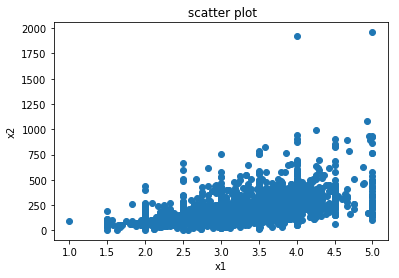

In [112]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(X[:,0], X[:,1])
ax.set_title(u" scatter plot")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

In [113]:
X = sp.stats.zscore(X, axis=0)

In [114]:
X_num = X.shape[1] #Xの列数
X_num

29

In [115]:
for i in range(X_num):
    print("mean:",np.mean(X[:,i]))
    print("std:",np.std(X[:,i]))

mean: 3.38608954658e-15
std: 1.0
mean: 1.16445439333e-15
std: 1.0
mean: 1.69196784892e-16
std: 1.0
mean: 3.43179900332e-16
std: 1.0
mean: 8.84274568846e-17
std: 1.0
mean: -1.23367669889e-16
std: 1.0
mean: -6.14445184171e-17
std: 1.0
mean: 2.39316527428e-19
std: 1.0
mean: 4.76239889582e-17
std: 1.0
mean: 3.24273894665e-17
std: 1.0
mean: 5.74359665827e-17
std: 1.0
mean: -1.6333352997e-16
std: 1.0
mean: 2.81196919728e-18
std: 1.0
mean: 5.13932242652e-17
std: 1.0
mean: -2.78803754454e-17
std: 1.0
mean: -1.93248095898e-17
std: 1.0
mean: 9.63249022898e-17
std: 1.0
mean: 9.85984093003e-17
std: 1.0
mean: 3.05128572471e-18
std: 1.0
mean: -6.32393923728e-17
std: 1.0
mean: 1.03265081585e-16
std: 1.0
mean: 3.71538908832e-17
std: 1.0
mean: 3.60769665098e-17
std: 1.0
mean: 5.1453053397e-17
std: 1.0
mean: -4.90598881227e-18
std: 1.0
mean: -6.44958041418e-17
std: 1.0
mean: 6.08462270986e-17
std: 1.0
mean: 7.14359834373e-17
std: 1.0
mean: -1.18820655868e-16
std: 1.0


### モデリング

In [116]:
# 可視化関数
def cluter_visualize(X, y_km):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
    cluster_ids = list(set(y_km))
    for k in range(len(cluster_ids)):
        cluster_id = cluster_ids[k]
        label_ = "clutser = %d"%cluster_id
        data_by_cluster = X[y_km == cluster_id]
        ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)

    ax.set_title(u"Clustering")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc='lower right')

In [117]:
#km = KMeans(n_clusters=3, n_jobs=-1,random_state=0).fit(X)

In [118]:
km = KMeans(n_clusters=4, n_jobs=-1,random_state=0).fit(X)

In [119]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [120]:
y_km = km.labels_

In [121]:
#km.cluster_centers_

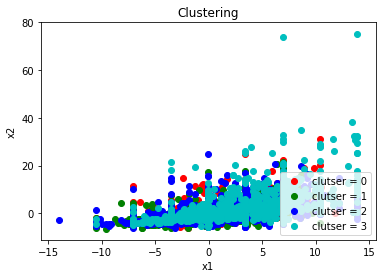

In [122]:
cluter_visualize(X, y_km)

###### クラスタ内誤差平方和（SSE=Cluster Intertia）

In [123]:
print ('Distortion: %.2f'% km.inertia_)

Distortion: 2970336.61


###### エルボー法（最適なクラスタ数を）

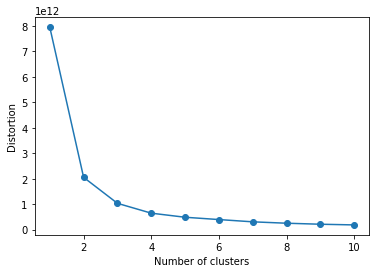

In [124]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで
    km = KMeans(n_clusters=i,
                n_jobs=-1,
                random_state=0)
    km.fit(data)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

###### シルエット分析

For n_clusters = 2 The average silhouette_score is : 0.101497314378


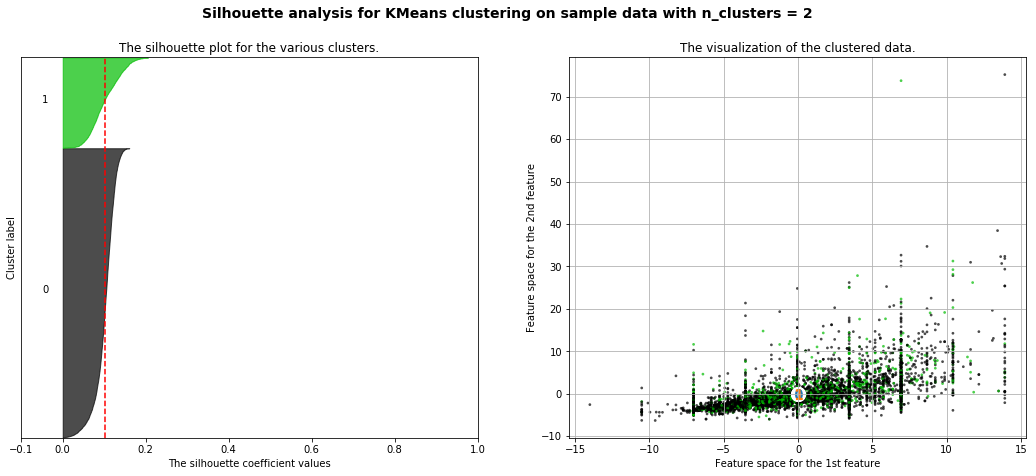

For n_clusters = 3 The average silhouette_score is : 0.0968115486358


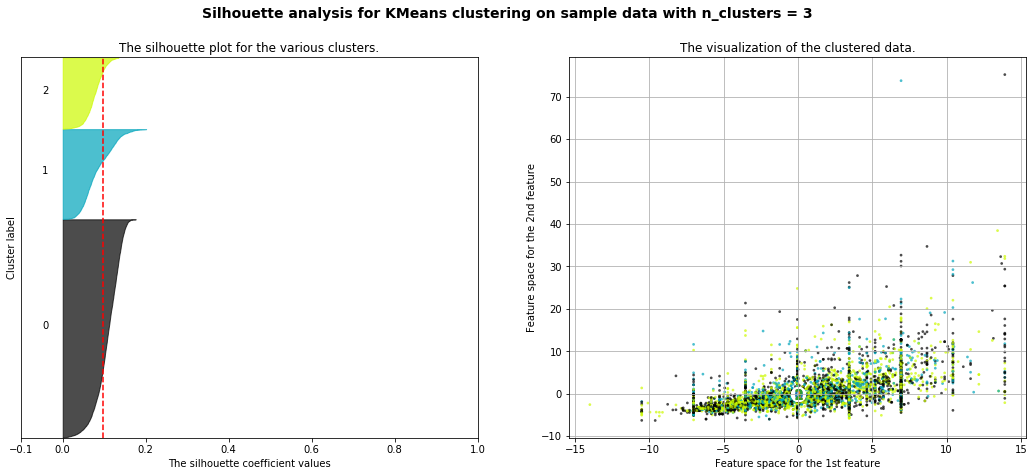

For n_clusters = 4 The average silhouette_score is : 0.101634512535


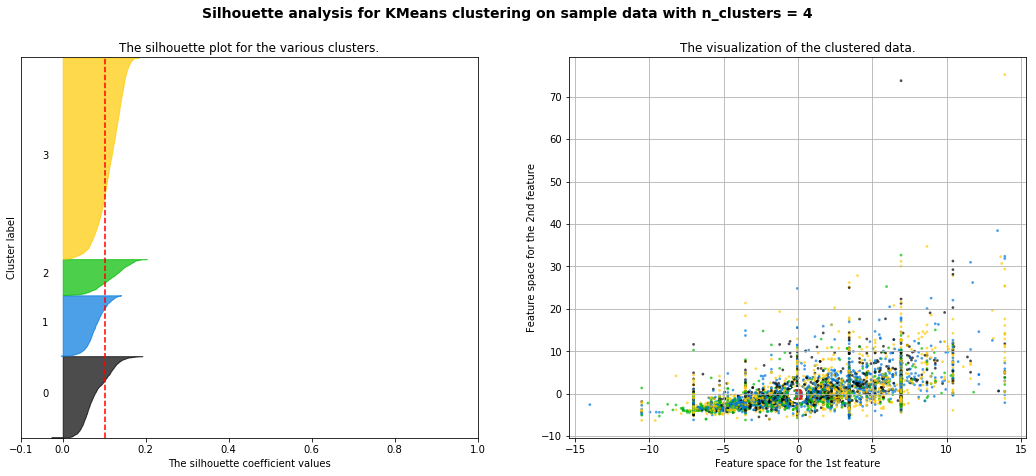

For n_clusters = 5 The average silhouette_score is : 0.0870982060234


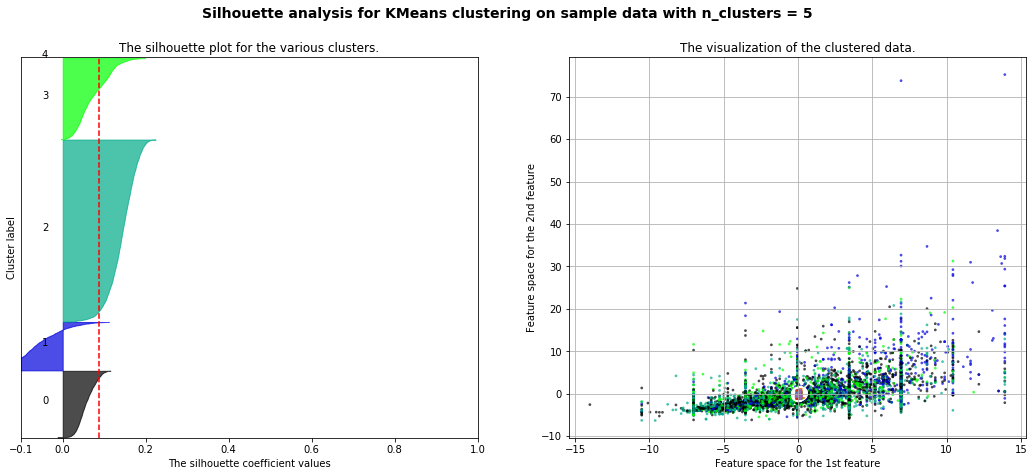

In [125]:
#len(X) or samplesize
range_n_clusters = [2,3,4,5]
samplesize = 10000

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, samplesize + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1,n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    
    ##ランダムサンプリングして評価
    #X,cluster_labelsをtemp_dataに格納
    temp_data = pd.DataFrame(X, columns=list(data.columns))
    temp_data['cluster_id'] = cluster_labels

    #ランダムサンプリングしてsample_dataに格納
    sampler = np.random.permutation(len(temp_data))
    sample_data = temp_data.take(sampler[:samplesize])

    #sample_dataをX2,cluster_labels2に再分割
    X2 = np.array(sample_data[data.columns])
    cluster_labels2 = np.array(sample_data['cluster_id'])
    
    silhouette_avg = silhouette_score(X2, cluster_labels2)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X2, cluster_labels2,metric='euclidean')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels2 == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=100)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.grid()
    plt.show()

## クラスタリング後のデータ理解

In [126]:
cluster_data = book_data

In [127]:
cluster_data['cluster_id'] = y_km

In [128]:
cluster_data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,srch_saturday_night_flg,dest_rank,window_week,window_today,window_previous_day,prop_historical_price,special_price,long_stay_flg,srch_evening_flg,cluster_id
0,8,2013-03-20 17:50:44,5,219,3.00681,157.088418,219,27669,3,3.5,...,0,0,1,1,0,101.494032,0.038387,0,1,2
1,25,2012-12-11 13:03:42,5,219,3.00681,157.088418,219,23228,4,4.0,...,0,0,1,1,0,84.774942,0.158183,0,0,1
2,28,2012-11-26 10:13:17,5,219,3.00681,157.088418,219,13996,4,4.0,...,0,0,4,0,0,159.174327,0.123737,0,0,2
3,39,2013-04-06 18:08:58,5,219,3.00681,157.088418,219,109855,2,3.5,...,1,0,1,0,0,57.397457,0.010535,0,1,0
4,53,2013-02-13 07:00:24,5,219,3.00681,157.088418,219,101178,4,4.5,...,1,0,3,0,0,210.608298,0.062191,0,0,1


In [129]:
cluster_data.describe()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,srch_saturday_night_flg,dest_rank,window_week,window_today,window_previous_day,prop_historical_price,special_price,long_stay_flg,srch_evening_flg,cluster_id
count,118762.000000,118762.0,118762.0,118762.000000,118762.000000,118762.0,118762.000000,118762.000000,118762.000000,118762.000000,...,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000,118762.000000
mean,331977.673001,5.0,219.0,3.006810,157.088418,219.0,70020.035340,3.070755,3.973404,0.774532,...,0.578459,0.378825,3.878219,0.096529,0.110961,158.367003,0.055352,0.040846,0.254543,1.219161
std,192371.036594,0.0,0.0,0.143254,23.949063,0.0,40749.877928,0.880631,0.662440,0.417892,...,0.493808,1.514937,5.450776,0.295317,0.314086,79.570396,0.062421,0.197935,0.435606,0.930350
min,8.000000,5.0,219.0,1.000000,5.690000,219.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,5.002811,-1.752060,0.000000,0.000000,0.000000
25%,165365.500000,5.0,219.0,3.006810,157.088418,219.0,34635.000000,3.000000,3.500000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,102.514064,0.020671,0.000000,0.000000,1.000000
50%,331306.500000,5.0,219.0,3.006810,157.088418,219.0,69067.000000,3.000000,4.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,139.770250,0.053855,0.000000,0.000000,1.000000
75%,498607.250000,5.0,219.0,3.006810,157.088418,219.0,105132.000000,4.000000,4.500000,1.000000,...,1.000000,0.000000,4.000000,0.000000,0.000000,192.481491,0.090181,0.000000,1.000000,2.000000
max,665567.000000,5.0,219.0,5.000000,1958.700000,219.0,140816.000000,5.000000,5.000000,1.000000,...,1.000000,10.000000,67.000000,1.000000,1.000000,497.701251,0.390707,1.000000,1.000000,3.000000


In [130]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118762 entries, 0 to 118761
Data columns (total 53 columns):
srch_id                        118762 non-null int64
date_time                      118762 non-null datetime64[ns]
site_id                        118762 non-null int64
visitor_location_country_id    118762 non-null int64
visitor_hist_starrating        118762 non-null float64
visitor_hist_adr_usd           118762 non-null float64
prop_country_id                118762 non-null int64
prop_id                        118762 non-null int64
prop_starrating                118762 non-null int64
prop_review_score              118762 non-null float64
prop_brand_bool                118762 non-null int64
prop_location_score1           118762 non-null float64
prop_location_score2           118762 non-null float64
prop_log_historical_price      118762 non-null float64
price_usd                      118762 non-null float64
promotion_flag                 118762 non-null int64
srch_destination_i

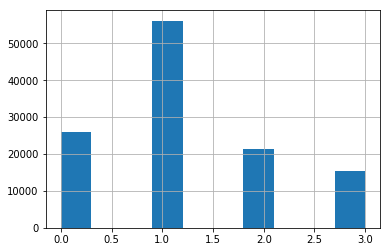

In [131]:
cluster_data['cluster_id'].hist()

date_week

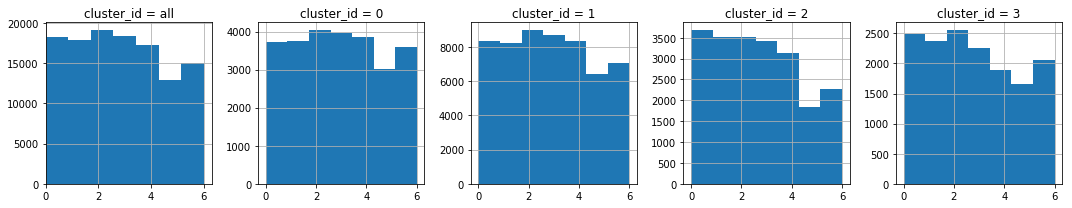

In [164]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'date_dow'
bin_num = 7
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    #plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

date_hour

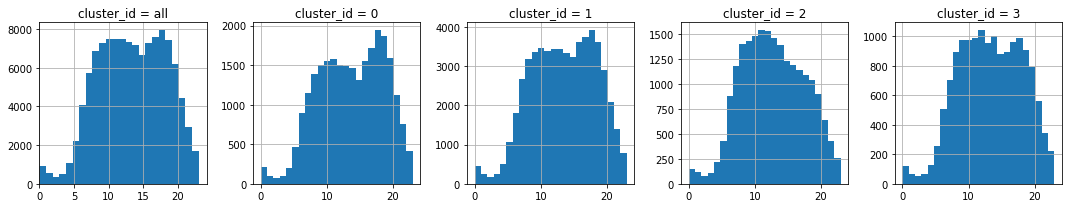

In [165]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'date_hour'
bin_num = 24
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    #plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

visitor_hist_starrating

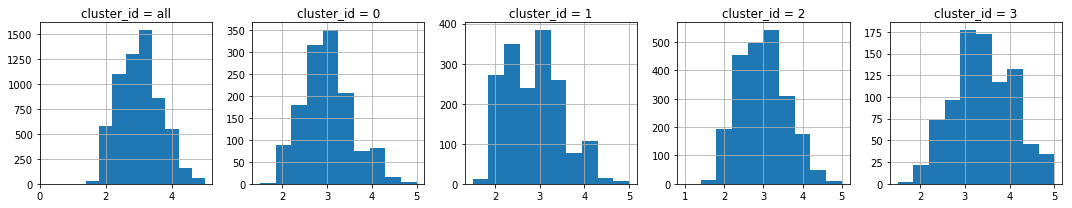

In [169]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'visitor_hist_starrating'
bin_num = 10
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[cluster_data['visitor_hist_book']==1][compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[np.logical_and(cluster_data['visitor_hist_book']==1,cluster_data[change_col]==i)][compare_col].hist(bins=bin_num)
    #plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

srch_booking_window

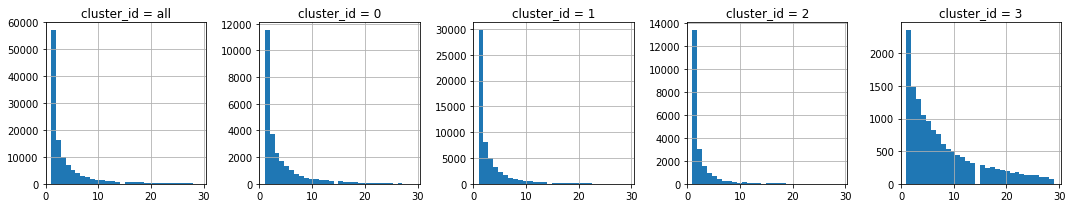

In [263]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'window_week'
bin_num = 30
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[cluster_data['window_week']<30][compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[np.logical_and(cluster_data['window_week']<30,cluster_data[change_col]==i)][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

srch_adults_count

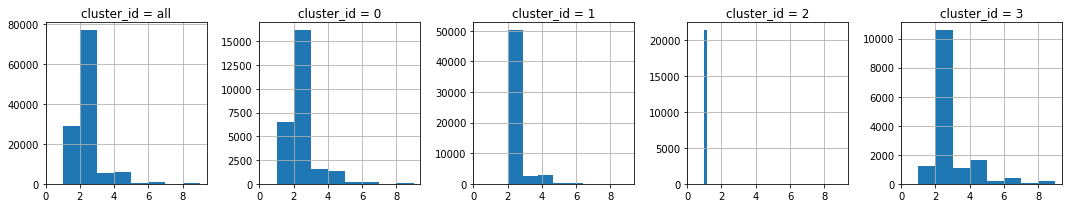

In [187]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'srch_adults_count'
bin_num = 8
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

srch_children_count

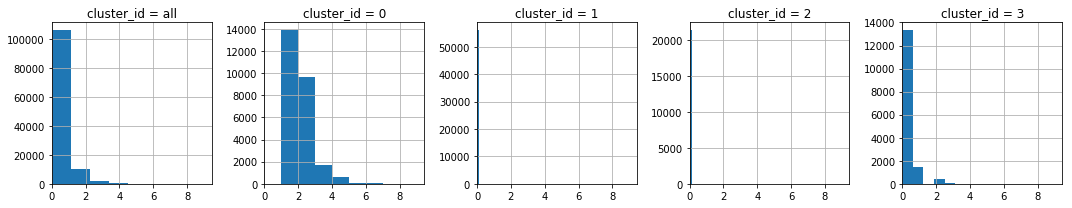

In [188]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'srch_children_count'
bin_num = 8
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

gross_bookings_usd

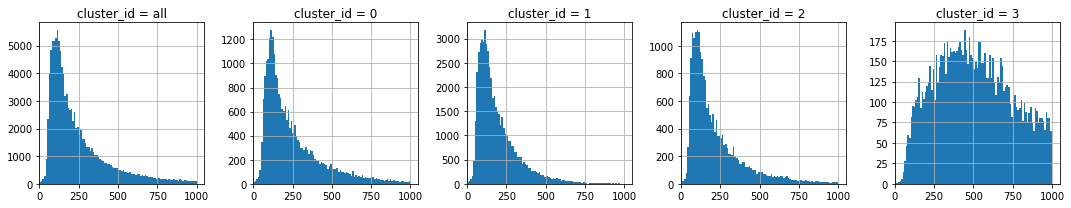

In [197]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'gross_bookings_usd'
bin_num = 100
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[cluster_data['gross_bookings_usd']<1000][compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[np.logical_and(cluster_data['gross_bookings_usd']<1000,cluster_data[change_col]==i)][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

visitor_hist_book

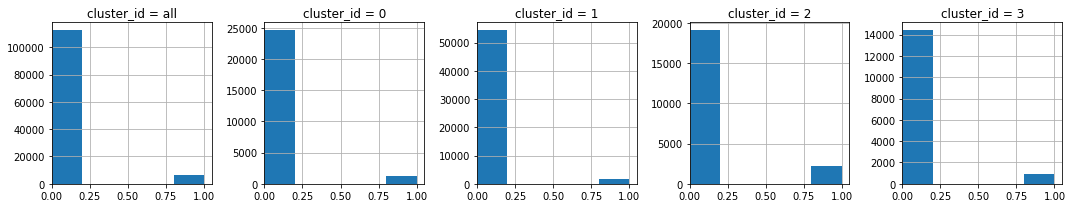

In [200]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'visitor_hist_book'
bin_num = 5
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

date_month

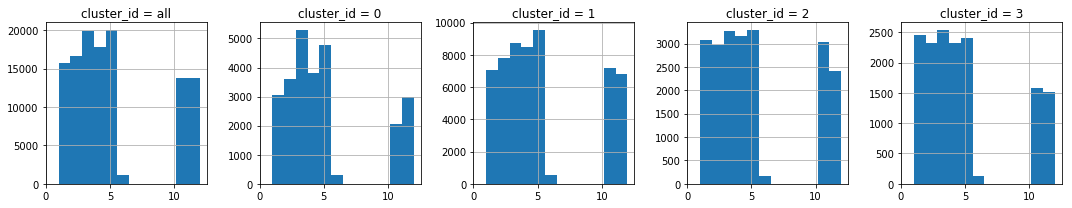

In [201]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'date_month'
bin_num = 12
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

srch_saturday_night_flg

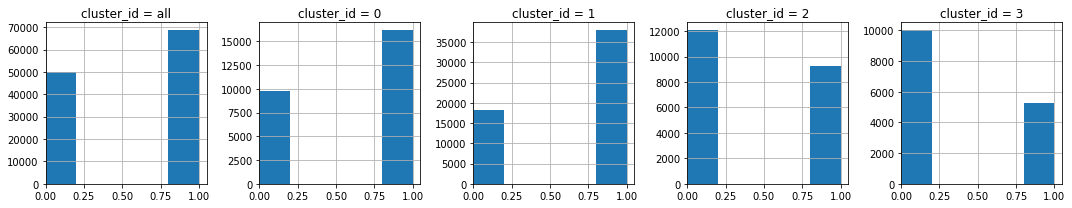

In [207]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'srch_saturday_night_flg'
bin_num = 5
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

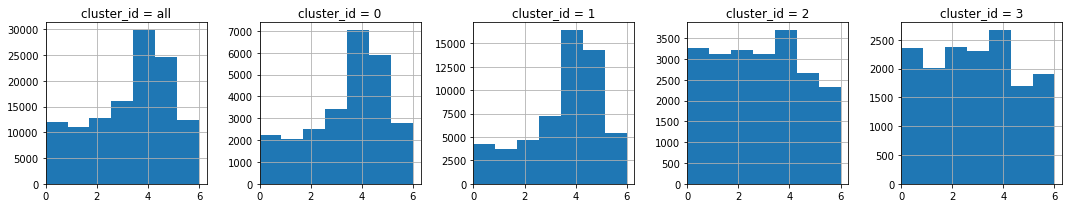

In [210]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'stay_date_dow'
bin_num = 7
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

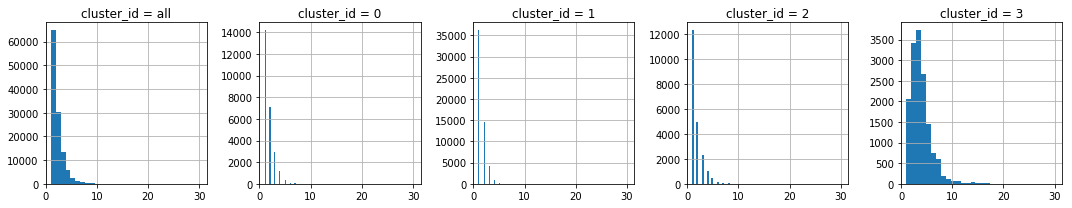

In [211]:
#ヒストグラム×4グラフ(all+3)
change_col = 'cluster_id'
compare_col = 'srch_length_of_stay'
bin_num = 30
cluster_num = 4

fig = plt.figure(figsize=(15,3))
#all
plt.subplot(1,cluster_num+1,1)
cluster_data[compare_col].hist(bins=bin_num)
xl = plt.xlim #allのx軸の範囲を抽出
x_min_max = xl(0) #x軸の範囲をセット
yl = plt.ylim #allのy軸の範囲を抽出
y_min_max = yl(0) #y軸の範囲をセット
plt.title('%s = all' % (change_col))
#+3
for i in range(0,cluster_num):
    plt.subplot(1,cluster_num+1,i+2)
    cluster_data[cluster_data[change_col]==i][compare_col].hist(bins=bin_num)
    plt.xlim(x_min_max) #y軸を固定したくない時はここをコメントアウト
    #plt.ylim(y_min_max) #y軸を固定したくない時はここをコメントアウト
    plt.title('%s = %d' % (change_col,i))  
plt.tight_layout()

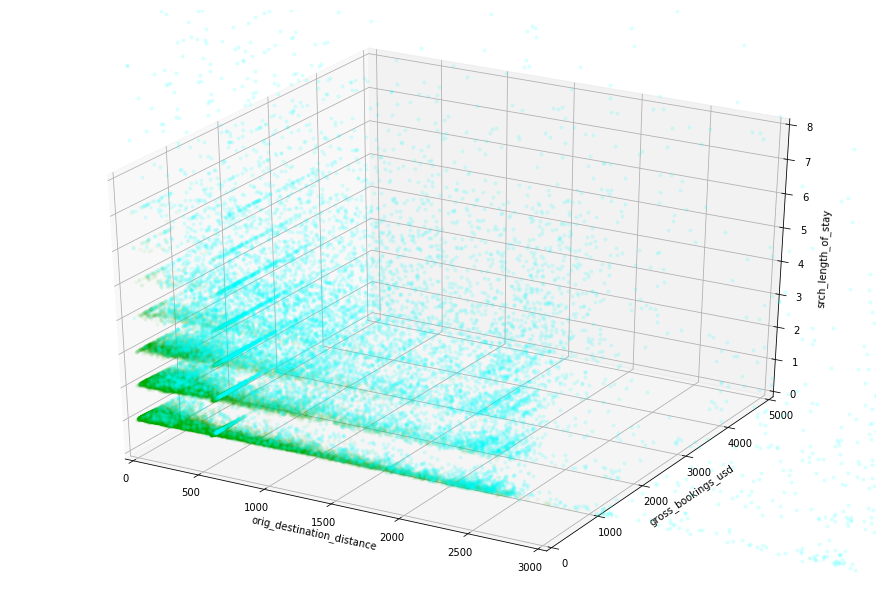

In [259]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt

x_compare_col = 'orig_destination_distance'
y_compare_col = 'gross_bookings_usd'
z_compare_col = 'srch_length_of_stay'

# グラフ作成
fig = pyplot.figure(figsize=(12, 8))
ax = Axes3D(fig)

# 軸ラベルの設定
ax.set_xlabel(x_compare_col)
ax.set_ylabel(y_compare_col)
ax.set_zlabel(z_compare_col)

# 表示範囲の設定
ax.set_xlim(0, 3000)
ax.set_ylim(0, 5000)
ax.set_zlim(0, 8)

# 抽出条件設定
d1 = cluster_data[cluster_data['cluster_id']==1]
d2 = cluster_data[cluster_data['cluster_id']==3]


# グラフ描画
ax.plot(d1[x_compare_col], d1[y_compare_col], d1[z_compare_col], "o", color="#00aa00", ms=4, mew=0, alpha=0.05)
ax.plot(d2[x_compare_col], d2[y_compare_col], d2[z_compare_col], "o", color="#00ffff", ms=4, mew=0, alpha=0.15)
pyplot.show()

### 変数の重要度の確認

In [222]:
exclude_cols = ['srch_id','prop_id'
                ,'site_id','visitor_location_country_id','prop_country_id'
                ,'click_bool','booking_bool'
                ,'date_time','date_week','srch_saturday_night_bool','srch_booking_window'
                ,'stay_date','stay_date_time','stay_date_week'
                ,'dest_rank','cluster_id'
                ,'gross_bookings_usd'
                ,'family_flg','business_flg']

In [224]:
feature_cols = [col for col in cluster_data.columns if col not in exclude_cols]

In [226]:
classifier_data = cluster_data[feature_cols]

###### ランダムフォレスト

In [227]:
y = np.array(cluster_data['cluster_id'])
X = np.array(classifier_data[feature_cols])

In [228]:
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [229]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [230]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [231]:
y_pred = rf.predict(X_test)

In [232]:
y_pred

array([0, 3, 2, ..., 1, 1, 1], dtype=int32)

In [233]:
y_test

array([0, 3, 2, ..., 1, 1, 1], dtype=int32)

In [234]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[ 7797,     0,     0,    85],
       [    0, 16570,     0,   231],
       [    0,     2,  6355,    20],
       [  134,   482,    58,  3895]])

In [235]:
print(classification_report(y_true=y_test, y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      7882
          1       0.97      0.99      0.98     16801
          2       0.99      1.00      0.99      6377
          3       0.92      0.85      0.89      4569

avg / total       0.97      0.97      0.97     35629



In [260]:
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

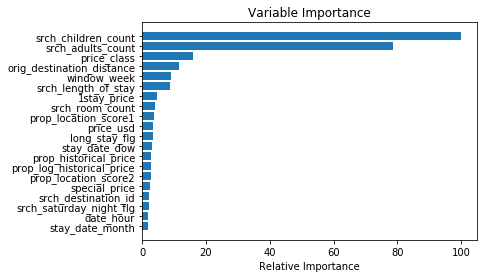

srch_children_count 100.0
srch_adults_count 78.5154588332
price_class 15.8759659586
orig_destination_distance 11.4560406823
window_week 8.99815977268
srch_length_of_stay 8.78380520992
1stay_price 4.77527308949
srch_room_count 3.9509164285
prop_location_score1 3.666027155
price_usd 3.40829014297
long_stay_flg 3.24846381967
stay_date_dow 3.13498718168
prop_historical_price 2.91259616093
prop_log_historical_price 2.69723491522
prop_location_score2 2.6096565518
special_price 2.54949876765
srch_destination_id 2.26587378184
srch_saturday_night_flg 2.19260772407
date_hour 1.82523147728
stay_date_month 1.67842437717
date_month 1.36038830052
date_dow 1.24442655021
prop_starrating 0.990336535332
prop_review_score 0.950500924441
promotion_flag 0.767508767633
visitor_hist_adr_usd 0.576205178527
prop_brand_bool 0.527453703658
visitor_hist_starrating 0.508194052624
visitor_hist_book 0.388778593285
srch_evening_flg 0.332500573207
high_season_flg 0.326485369409
window_today 0.291371974703
window_previ

In [261]:
varImpPlot(rf, feature_cols, topN=20, verbose=True)

###### 決定木

In [247]:
dt = DecisionTreeClassifier(max_leaf_nodes=4)

In [248]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [249]:
y_pred_proba = dt.predict_proba(X_test)
y_pred_proba

array([[  9.27390367e-01,   0.00000000e+00,   0.00000000e+00,
          7.26096334e-02],
       [  0.00000000e+00,   2.89666710e-01,   1.28683567e-04,
          7.10204607e-01],
       [  0.00000000e+00,   0.00000000e+00,   9.66685998e-01,
          3.33140022e-02],
       ..., 
       [  0.00000000e+00,   9.18799079e-01,   9.90859323e-05,
          8.11018356e-02],
       [  0.00000000e+00,   9.18799079e-01,   9.90859323e-05,
          8.11018356e-02],
       [  0.00000000e+00,   9.18799079e-01,   9.90859323e-05,
          8.11018356e-02]])

In [250]:
y_pred = dt.predict(X_test)
y_pred

array([0, 3, 2, ..., 1, 1, 1], dtype=int32)

In [251]:
y_test

array([0, 3, 2, ..., 1, 1, 1], dtype=int32)

In [252]:
ypred_flag = dt.predict(X_test, check_input=True)

In [253]:
confusion_matrix(y_true=y_test, y_pred=ypred_flag)

array([[ 7882,     0,     0,     0],
       [    0, 15854,     0,   947],
       [    0,     2,  6374,     1],
       [  540,  1448,   227,  2354]])

In [254]:
print(classification_report(y_true=y_test, y_pred=ypred_flag))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      7882
          1       0.92      0.94      0.93     16801
          2       0.97      1.00      0.98      6377
          3       0.71      0.52      0.60      4569

avg / total       0.90      0.91      0.90     35629



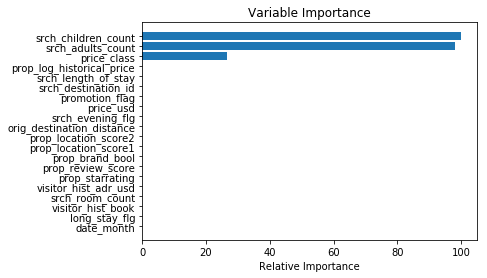

srch_children_count 100.0
srch_adults_count 98.1158585768
price_class 26.547932607
prop_log_historical_price 0.0
srch_length_of_stay 0.0
srch_destination_id 0.0
promotion_flag 0.0
price_usd 0.0
srch_evening_flg 0.0
orig_destination_distance 0.0
prop_location_score2 0.0
prop_location_score1 0.0
prop_brand_bool 0.0
prop_review_score 0.0
prop_starrating 0.0
visitor_hist_adr_usd 0.0
srch_room_count 0.0
visitor_hist_book 0.0
long_stay_flg 0.0
date_month 0.0
date_hour 0.0
date_dow 0.0
stay_date_month 0.0
stay_date_dow 0.0
high_season_flg 0.0
executive_flg 0.0
1stay_price 0.0
srch_saturday_night_flg 0.0
window_week 0.0
window_today 0.0
window_previous_day 0.0
prop_historical_price 0.0
special_price 0.0
visitor_hist_starrating 0.0


In [255]:
varImpPlot(dt, feature_cols, topN=20, verbose=True)